In [2]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cProfile
import pstats
import pandas as pd
from datetime import datetime
import os
import ast

In [3]:
import os
import sys

path_common=os.path.dirname(os.path.abspath(''))+"/Common/";
sys.path.append(path_common) #Adds common path to import the python files

# Analysis of tuning of new neural networks


In [4]:
#Common folders
results_newNN_folder="../../results/NewNN/"
def get_present_experiments(text_to_have,folder):
    file_path_list=[];
    for dirpath, dnames, fnames in os.walk(folder):
        for f in fnames:
            if (text_to_have in f) and f.endswith("_log.txt"):
                file_path_list.append(folder+f);
    return file_path_list;

def get_runs_of_experiment(log_filepath,folder):
    common_start=os.path.basename(log_filepath)[:-8];
    df_final=None;
    for dirpath, dnames, fnames in os.walk(folder):
        for f in fnames:
            if (common_start in f) and f.endswith(".csv"):
                if df_final is None:
                    df_final=pd.read_csv(folder+f);
                else:
                    df = pd.read_csv(folder+f);
                    df_final=pd.concat([df_final, df]);
    return df_final

def get_param(filepath,param):
    retVal=None
    with open(filepath, 'r') as fp:
        line = fp.readline()
        while line != "": #File not finished
            if line.find(param)!= -1: #Text found
                str_2_convert=line[len(param)+2:]
                if param=="activation" or param=="Comment":
                    retVal=str_2_convert; #We want the string!
                else:
                    retVal= 0 if ("None" in str_2_convert) else float(str_2_convert)
                break;
            line = fp.readline()
    return retVal;

def get_accs(df):
    all_accs=df.iloc[:,:3].to_numpy();
    all_means=np.mean(all_accs,axis=0);
    all_stds=np.std(all_accs,axis=0);
    all_maxs=np.max(all_accs,axis=0);
    train_mean=all_means[0];train_std=all_stds[0];train_max=all_maxs[0];
    valid_mean=all_means[1];valid_std=all_stds[1];valid_max=all_maxs[1];
    test_mean=all_means[2];test_std=all_stds[2];test_max=all_maxs[2];
    return train_mean,train_std,train_max,valid_mean,valid_std,valid_max,test_mean,test_std,test_max

In [5]:
def accs_stats_to_str(acc_mean,acc_std,acc_max):
    return '{:.2f}'.format(acc_mean*100) + "+-" +'{:.2f}'.format(acc_std*100) + "(" + '{:.2f}'.format(acc_max*100) +")"
def all_accs_stats_to_str(train_mean,train_std,train_max,valid_mean,valid_std,valid_max,test_mean,test_std,test_max):
    return [accs_stats_to_str(train_mean,train_std,train_max), accs_stats_to_str(valid_mean,valid_std,valid_max), accs_stats_to_str(test_mean,test_std,test_max)]

def string_loss_to_array(loss_str):
    return np.asarray(ast.literal_eval(loss_str.replace(" ", ",")));

def get_avg_losses(df):
    n_runs=len(df);n_epochs=len(string_loss_to_array(df.iloc[0,3]));
    indexes=[3,4,5];
    col_name=["Train","Valid","Train Aug"]
    mean_losses=[]; #To be generated
    std_losses=[]; #To be generated
    for i in range(len(indexes)):
        index_df=indexes[i];
        all_losses=np.zeros((n_runs,n_epochs))
        for j in range(n_runs):
            all_losses[j,:]=string_loss_to_array(df.iloc[j,index_df])
        mean_losses.append(np.mean(all_losses,axis=0))
        std_losses.append(np.std(all_losses,axis=0)/np.sqrt(n_runs))
    return mean_losses,std_losses
        
        

def compare_dfs(list_of_dfs,names,table_accs=True,plots=True):
    if table_accs:
        print("------------ Table comparison ----------------")
        list_table_accs=[]
        for i in range(len(list_of_dfs)):
            tm,ts,tM,vm,vs,vM,Tm,Ts,TM =get_accs(list_of_dfs[i])
            str_accs=all_accs_stats_to_str(tm,ts,tM,vm,vs,vM,Tm,Ts,TM)
            list_table_accs.append([names[i],str_accs[0],str_accs[1],str_accs[2],len(list_of_dfs[i])])
        df=pd.DataFrame(list_table_accs, columns=["Name","Train Accuracy","Valid Accuracy","Test Accuracy","nRuns"]);
        print(df);
        print("----------------------------------------------")
    if plots:
        print("------------ Plot comparison ----------------")
        n_plots=3; #Train, Valid, TrainAug losses
        f, axs = plt.subplots(n_plots, 1,figsize=(20,60))
        titles=["Train loss","Valid loss","Train aug loss"]
        for i in range(len(list_of_dfs)):
            mean_losses,std_losses=get_avg_losses(list_of_dfs[i]);
            n_epochs=len(mean_losses[0]);
            for j in range(n_plots):
                axs[j].errorbar(np.arange(n_epochs), mean_losses[j], yerr=std_losses[j]);
        
        for j in range(n_plots): 
            axs[j].set_title(titles[j])
            axs[j].legend(names)
            axs[j].set_ylim([0,2])
            axs[j].set_ylabel("Loss")
            axs[j].set_xlabel("Epoch")
            
def show_experiments_and_comments(results_folder):
    list_data=[];
    for dirpath, dnames, fnames in os.walk(results_folder):
        for f in fnames:
            if f.endswith("log.txt"):
                com=get_param(dirpath+"/"+f,"Comment")
                list_data.append([os.path.basename(dirpath),f,com])
    df=pd.DataFrame(list_data)
    return df;
def get_folder_and_filepath(res_folder,dir_name,file_name):
    dir_total=res_folder+dir_name+"/";
    return dir_total,dir_total+file_name;

def load_multiple_files(res_folder,dir_name,file_names):
    df_list=[];
    for fn in file_names:
        path_w_dir,file_path=get_folder_and_filepath(res_folder,dir_name,fn)
        df_list.append(get_runs_of_experiment(file_path,path_w_dir))
    df=pd.concat(df_list);
    return df;

In [5]:
df=show_experiments_and_comments(results_newNN_folder)
df

,0,1,2
0,AttResQuipu,20240418_13-57-44_LR_log.txt,None
1,Test,20240417_19-52-45_LR_log.txt,None
2,Test,20240417_16-24-15_LR_log.txt,None
3,QuipuModif,20240419_15-18-53_QuipuRes_log.txt,uipu but we add residual connections\n
4,QuipuModif,20240421_21-17-38_QuipuAttRes_log.txt,uipu but we add residual connections\n
5,Quipu,20240421_19-49-01_QuipuExtBrowFinal_log.txt,eproducing best quipuExt with brownian\n
6,Quipu,20240419_15-28-23_QuipuExtBrowFinal_log.txt,eproducing best quipuExt with brownian\n
7,Quipu,20240419_15-28-23_QuipuExtFinal_log.txt,eproducing best quipuExt without brownian\n
8,Quipu,20240419_12-10-05_QuipuNoBrow_log.txt,eproducing quipu in 50 epochs and with new set...
9,Quipu,20240419_12-11-14_QuipuFinalBrow_log.txt,eproducing quipu with new setup on the same te...


## Comparing initial structures

### Attention residual 1D based on Resnet
Here we start first by running the Quipu architecture with our tuning training (which doesnt use data from the quipus test set), and also uses our optimized training. Our optimized training is with early stopping, augmentation techniques done in cupy to better use the GPU. Then we also run an architecture we proposed with attention and residual connections based on resnet for 1d. We then observe the results when training:

------------ Table comparison ----------------
                    Name      Train Accuracy      Valid Accuracy  \
0                  Quipu  98.07+-0.23(98.45)  96.17+-0.30(96.73)   
1              QuipuBrow  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
2                    ARQ  96.85+-1.13(97.99)  95.01+-0.83(96.49)   
3  ARQ Dropout block 0.1  94.90+-1.14(96.69)  93.15+-1.34(95.13)   

        Test Accuracy  nRuns  
0  96.13+-0.30(96.88)     21  
1  95.76+-0.35(96.42)     27  
2  94.97+-0.82(96.06)     16  
3  93.29+-1.25(95.34)     20  
----------------------------------------------
------------ Plot comparison ----------------


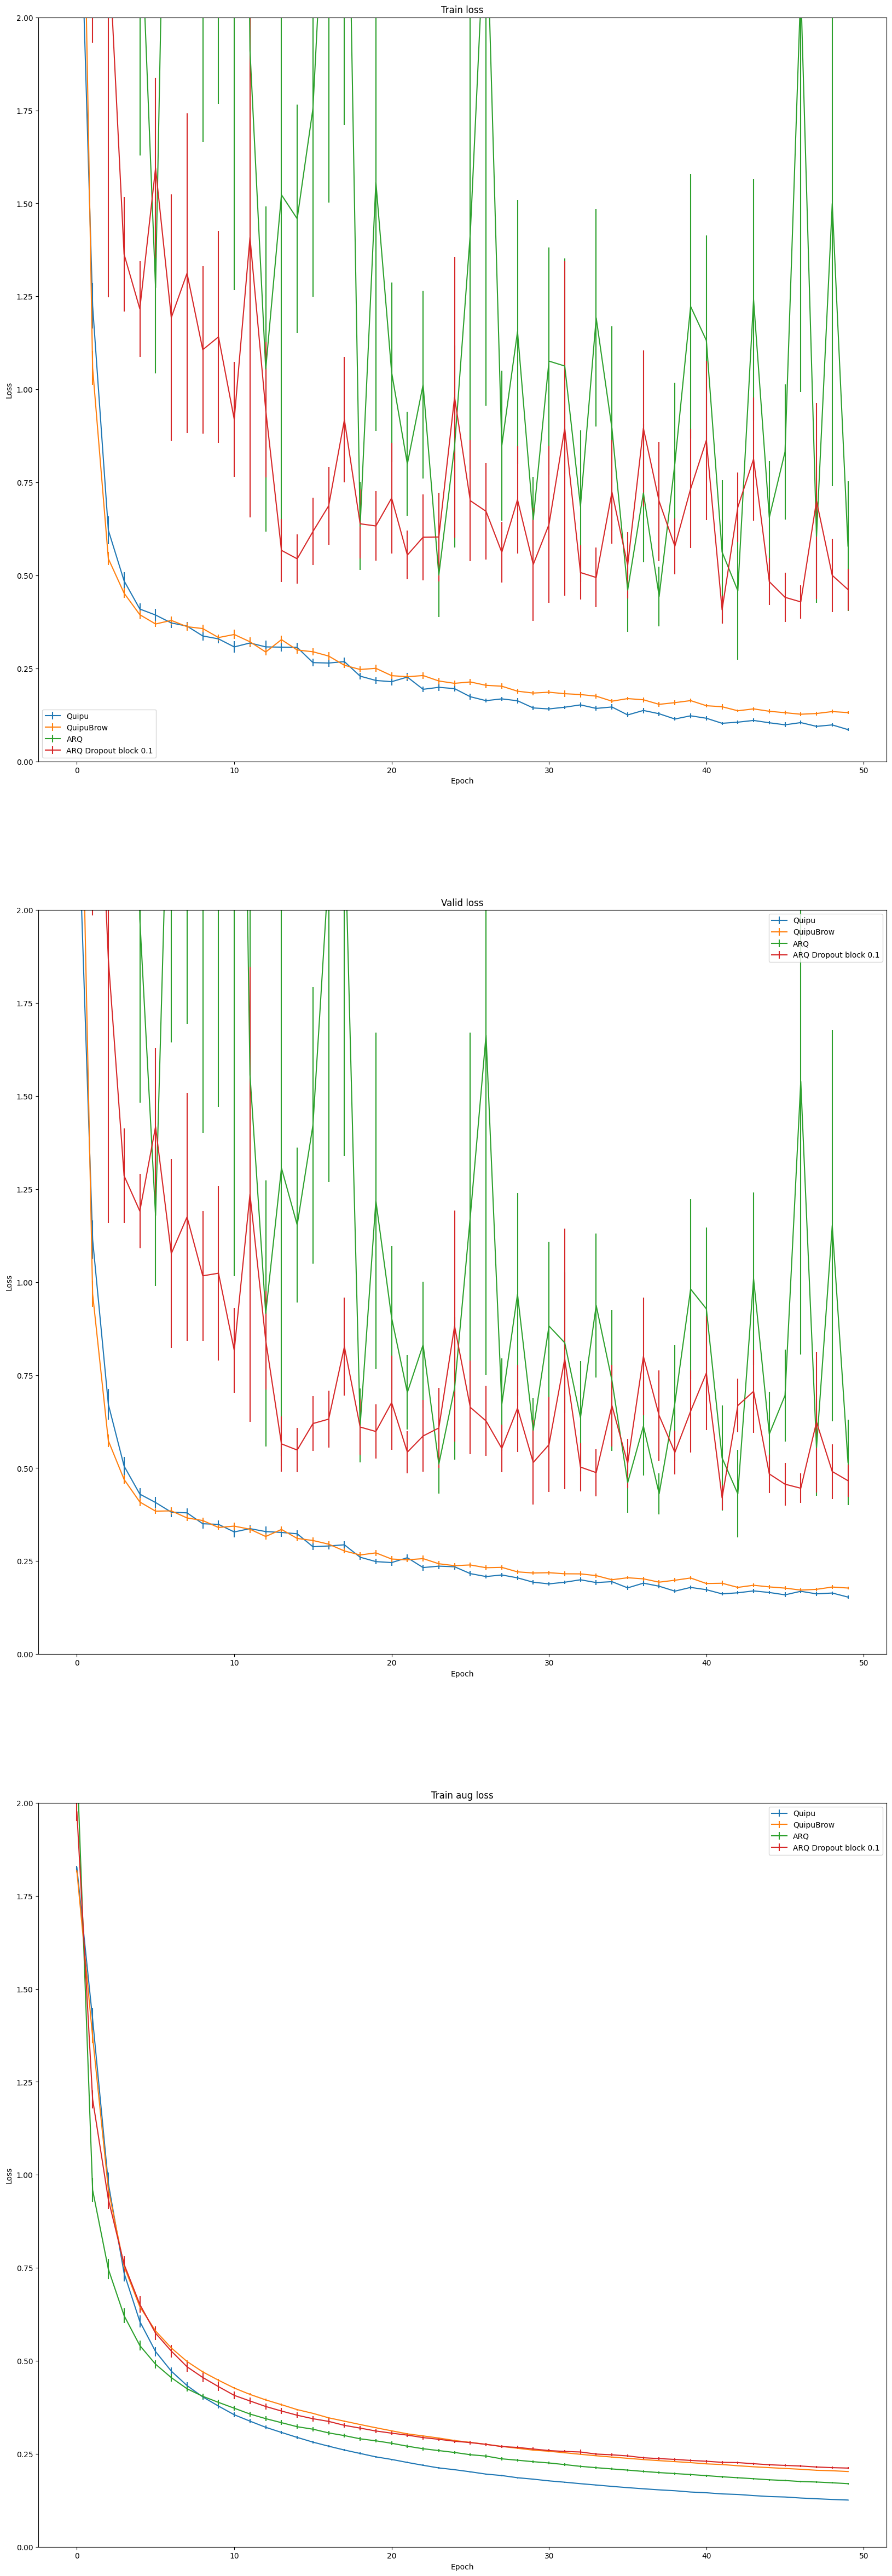

In [6]:

folder_tests,file_attresQuipuNoDropout=get_folder_and_filepath(results_newNN_folder,"Test","20240417_19-52-45_LR_log.txt")
df_AttResQuipu=get_runs_of_experiment(file_attresQuipuNoDropout,folder_tests)

folder_AttRes,file_attresQuipuDropout=get_folder_and_filepath(results_newNN_folder,"AttResQuipu","20240418_13-57-44_LR_log.txt")
df_AttResQuipuDropout=get_runs_of_experiment(file_attresQuipuDropout,folder_AttRes)

folder_Quipu,file_Quipu=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_12-10-05_QuipuNoBrow_log.txt")
df_Quipu=get_runs_of_experiment(file_Quipu,folder_Quipu)

folder_Quipu,file_QuipuBrow=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_10-59-10_LR_log.txt")
df_QuipuBrow=get_runs_of_experiment(file_QuipuBrow,folder_Quipu)

compare_dfs([df_Quipu,df_QuipuBrow,df_AttResQuipu,df_AttResQuipuDropout],["Quipu","QuipuBrow","ARQ","ARQ Dropout block 0.1"])

First: Quipu without brow has lower losses which makes sense, but in the test set we have shown before that after long training they kinda generalize similar (better with brow. So our baseline is the Quipu with brownian!  Anyways the structure proposed has very noisy train and valid losses, and higher than the quipu with brownian. So then we start searching other starting points to modify.

------------ Table comparison ----------------
                         Name      Train Accuracy      Valid Accuracy  \
0                   QuipuBrow  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
1                QuipuResBrow  97.81+-0.21(98.20)  96.09+-0.30(96.75)   
2             QuipuAttResBrow  97.83+-0.27(98.17)  96.08+-0.31(96.55)   
3  QuipuAttResBrowMoreDropout  97.38+-0.33(97.93)  95.66+-0.36(96.88)   

        Test Accuracy  nRuns  
0  95.76+-0.35(96.42)     27  
1  96.04+-0.32(96.62)     42  
2  96.02+-0.36(96.71)     29  
3  95.68+-0.38(96.35)     28  
----------------------------------------------
------------ Plot comparison ----------------


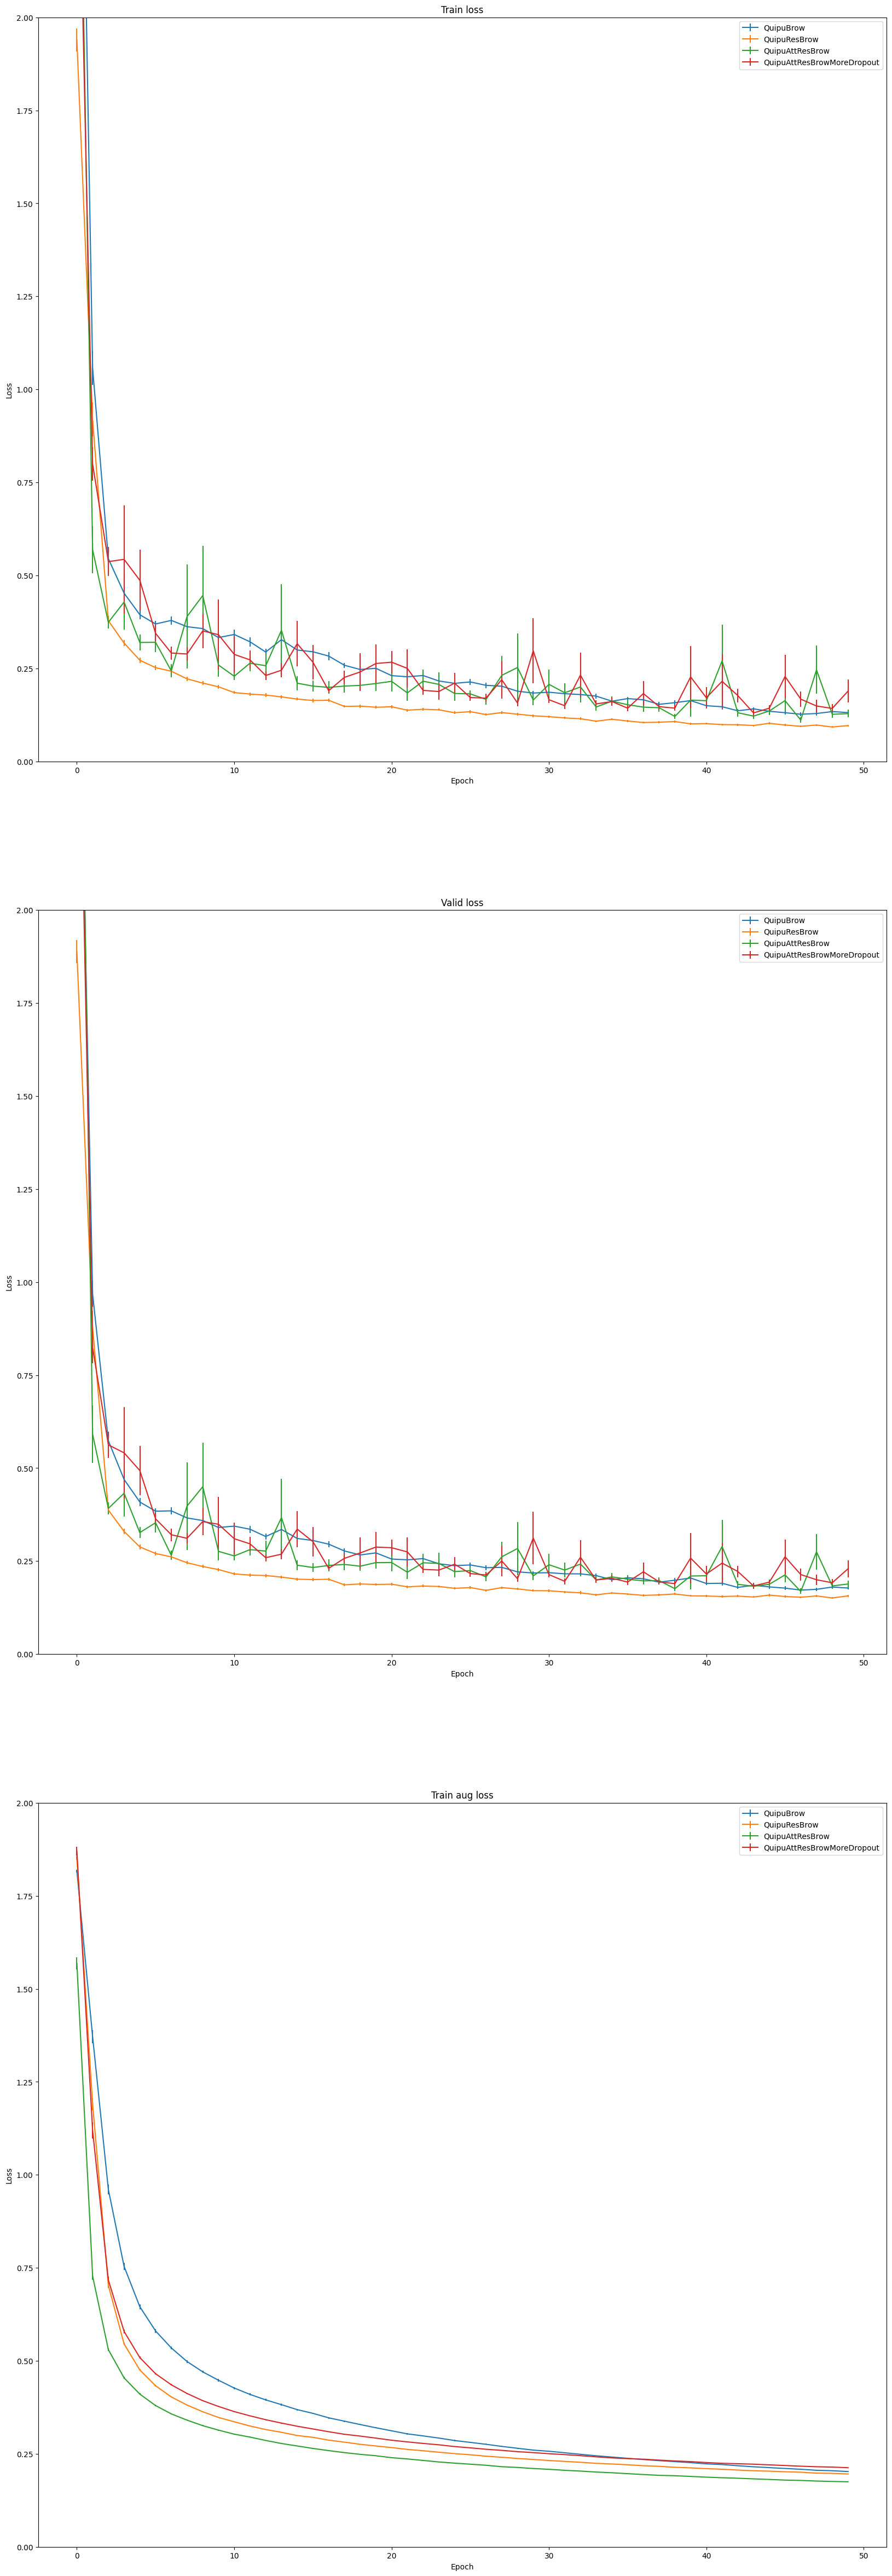

In [7]:
folder_quipumodif,file_QuipuRes=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240419_15-18-53_QuipuRes_log.txt")
df_QuipuRes=get_runs_of_experiment(file_QuipuRes,folder_quipumodif)

folder_quipumodif,file_QuipuAttRes=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240421_21-17-38_QuipuAttRes_log.txt")
df_QuipuAttRes=get_runs_of_experiment(file_QuipuAttRes,folder_quipumodif)

folder_quipumodif,file_QuipuAttResMoreDropout=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240422_10-47-52_QuipuAttResD_log.txt")
df_QuipuAttResMoreDropout=get_runs_of_experiment(file_QuipuAttResMoreDropout,folder_quipumodif)


compare_dfs([df_QuipuBrow,df_QuipuRes,df_QuipuAttRes,df_QuipuAttResMoreDropout],["QuipuBrow","QuipuResBrow","QuipuAttResBrow","QuipuAttResBrowMoreDropout"])

The residual looks with better results, and the skip connection had much more noisy curves. However this behaviour is suspected to be because of a bug given the axis of the batchnorm and multiply layers, so after 22/04/2024 18:00 this bugg is solved and ran again the same.

------------ Table comparison ----------------
              Name      Train Accuracy      Valid Accuracy  \
0        QuipuBrow  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
1     QuipuResBrow  97.81+-0.21(98.20)  96.09+-0.30(96.75)   
2  QuipuAttResBrow  97.78+-0.28(98.06)  96.04+-0.32(96.37)   

        Test Accuracy  nRuns  
0  95.76+-0.35(96.42)     27  
1  96.04+-0.32(96.62)     42  
2  96.17+-0.02(96.18)      2  
----------------------------------------------
------------ Plot comparison ----------------


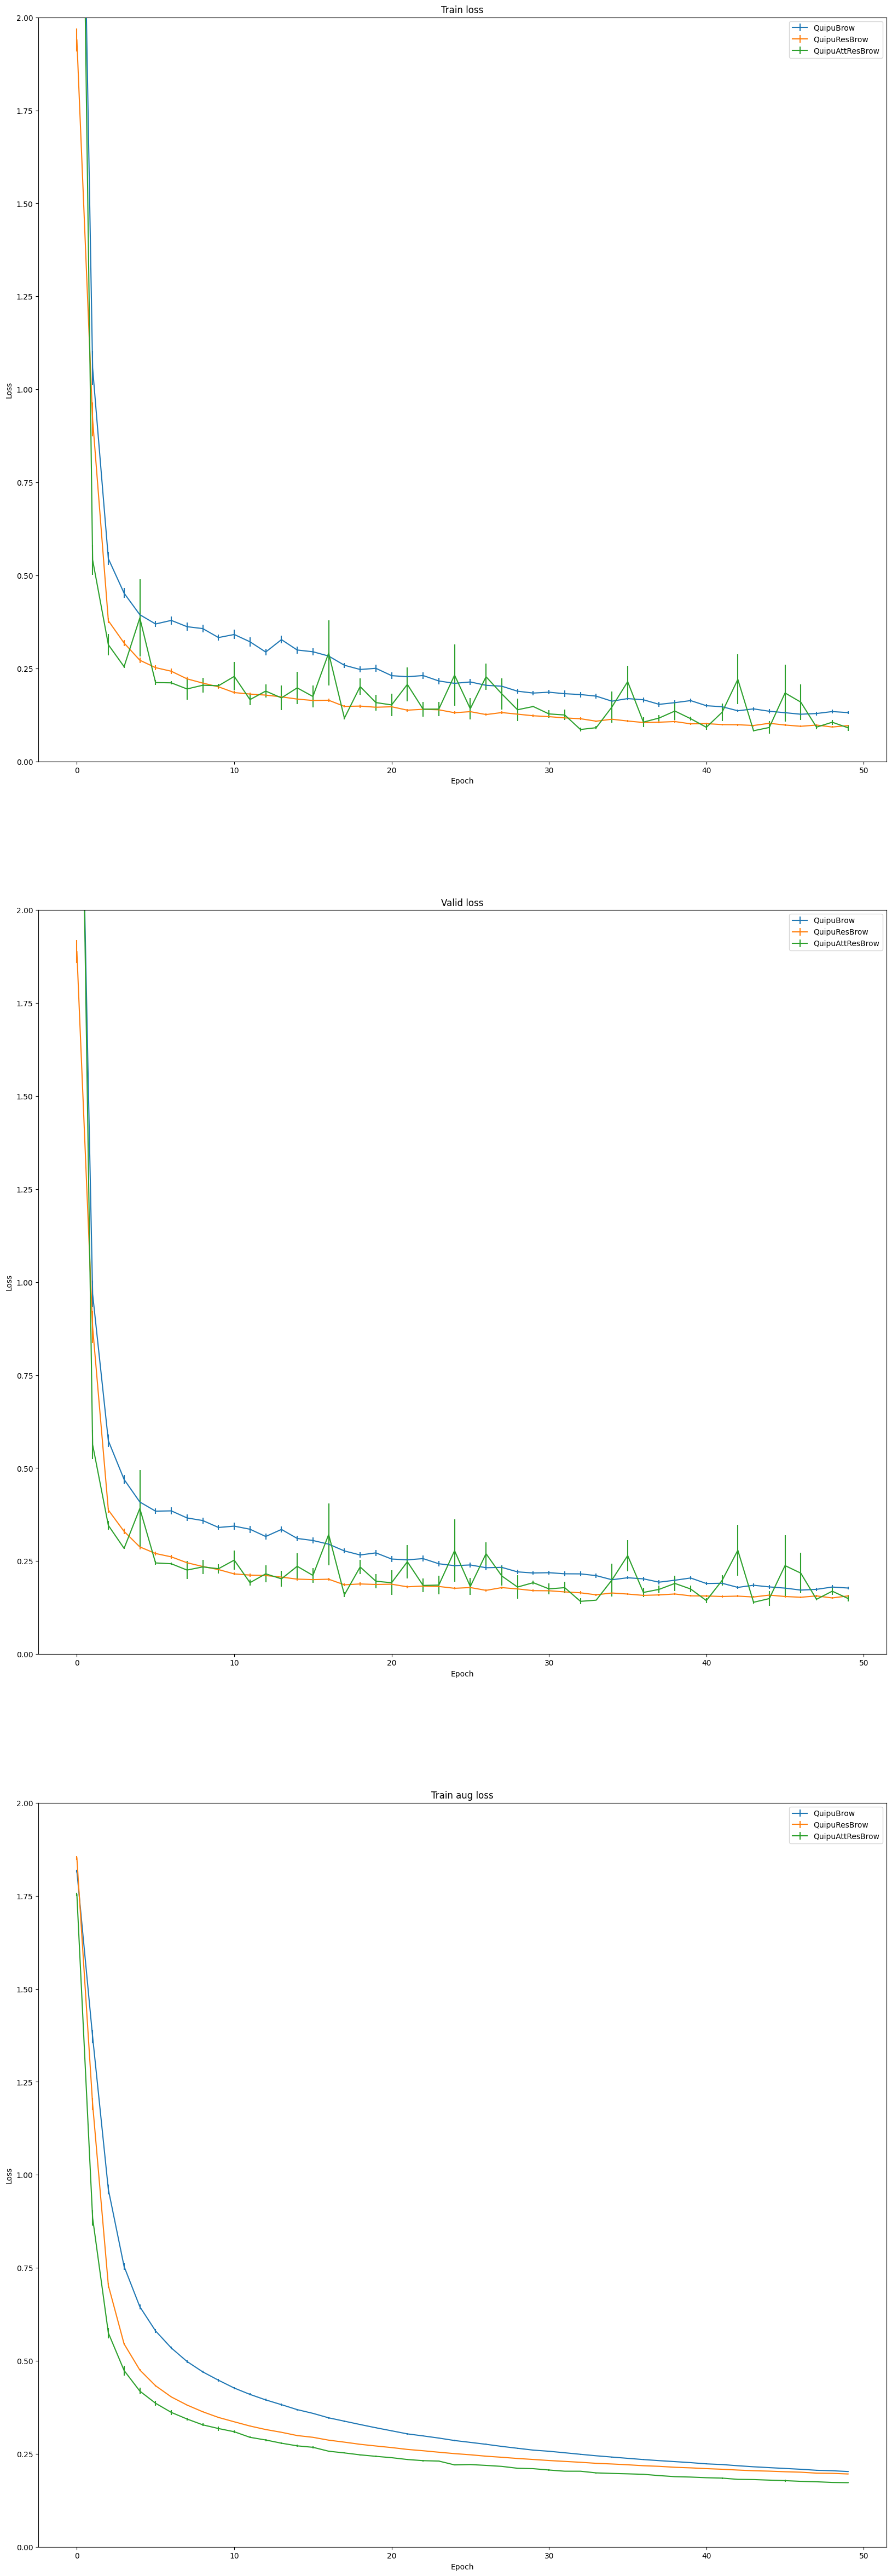

In [13]:
folder_quipumodif,file_QuipuAttRes=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240422_19-10-36_QuipuAttResD_log.txt")
df_QuipuAttRes=get_runs_of_experiment(file_QuipuAttRes,folder_quipumodif)

compare_dfs([df_QuipuBrow,df_QuipuRes,df_QuipuAttRes],["QuipuBrow","QuipuResBrow","QuipuAttResBrow"])

### Residual based on Quipu

Here we just use Quipu but we add residual connections to see if we spot a change

# Results on final test dataset

------------ Table comparison ----------------
           Name      Train Accuracy      Valid Accuracy       Test Accuracy  \
0         Quipu  99.11+-0.24(99.44)  96.79+-0.17(96.97)  93.99+-0.58(94.46)   
1     QuipuBrow  98.37+-0.20(98.77)  96.45+-0.32(97.11)  93.86+-0.36(94.34)   
2      QuipuExt  98.73+-0.29(99.28)  96.71+-0.29(97.46)  93.87+-0.39(94.66)   
3  QuipuExtBrow  98.92+-0.23(99.24)  96.84+-0.28(97.35)  93.90+-0.39(94.69)   

   nRuns  
0      9  
1     18  
2     18  
3     18  
----------------------------------------------
------------ Plot comparison ----------------


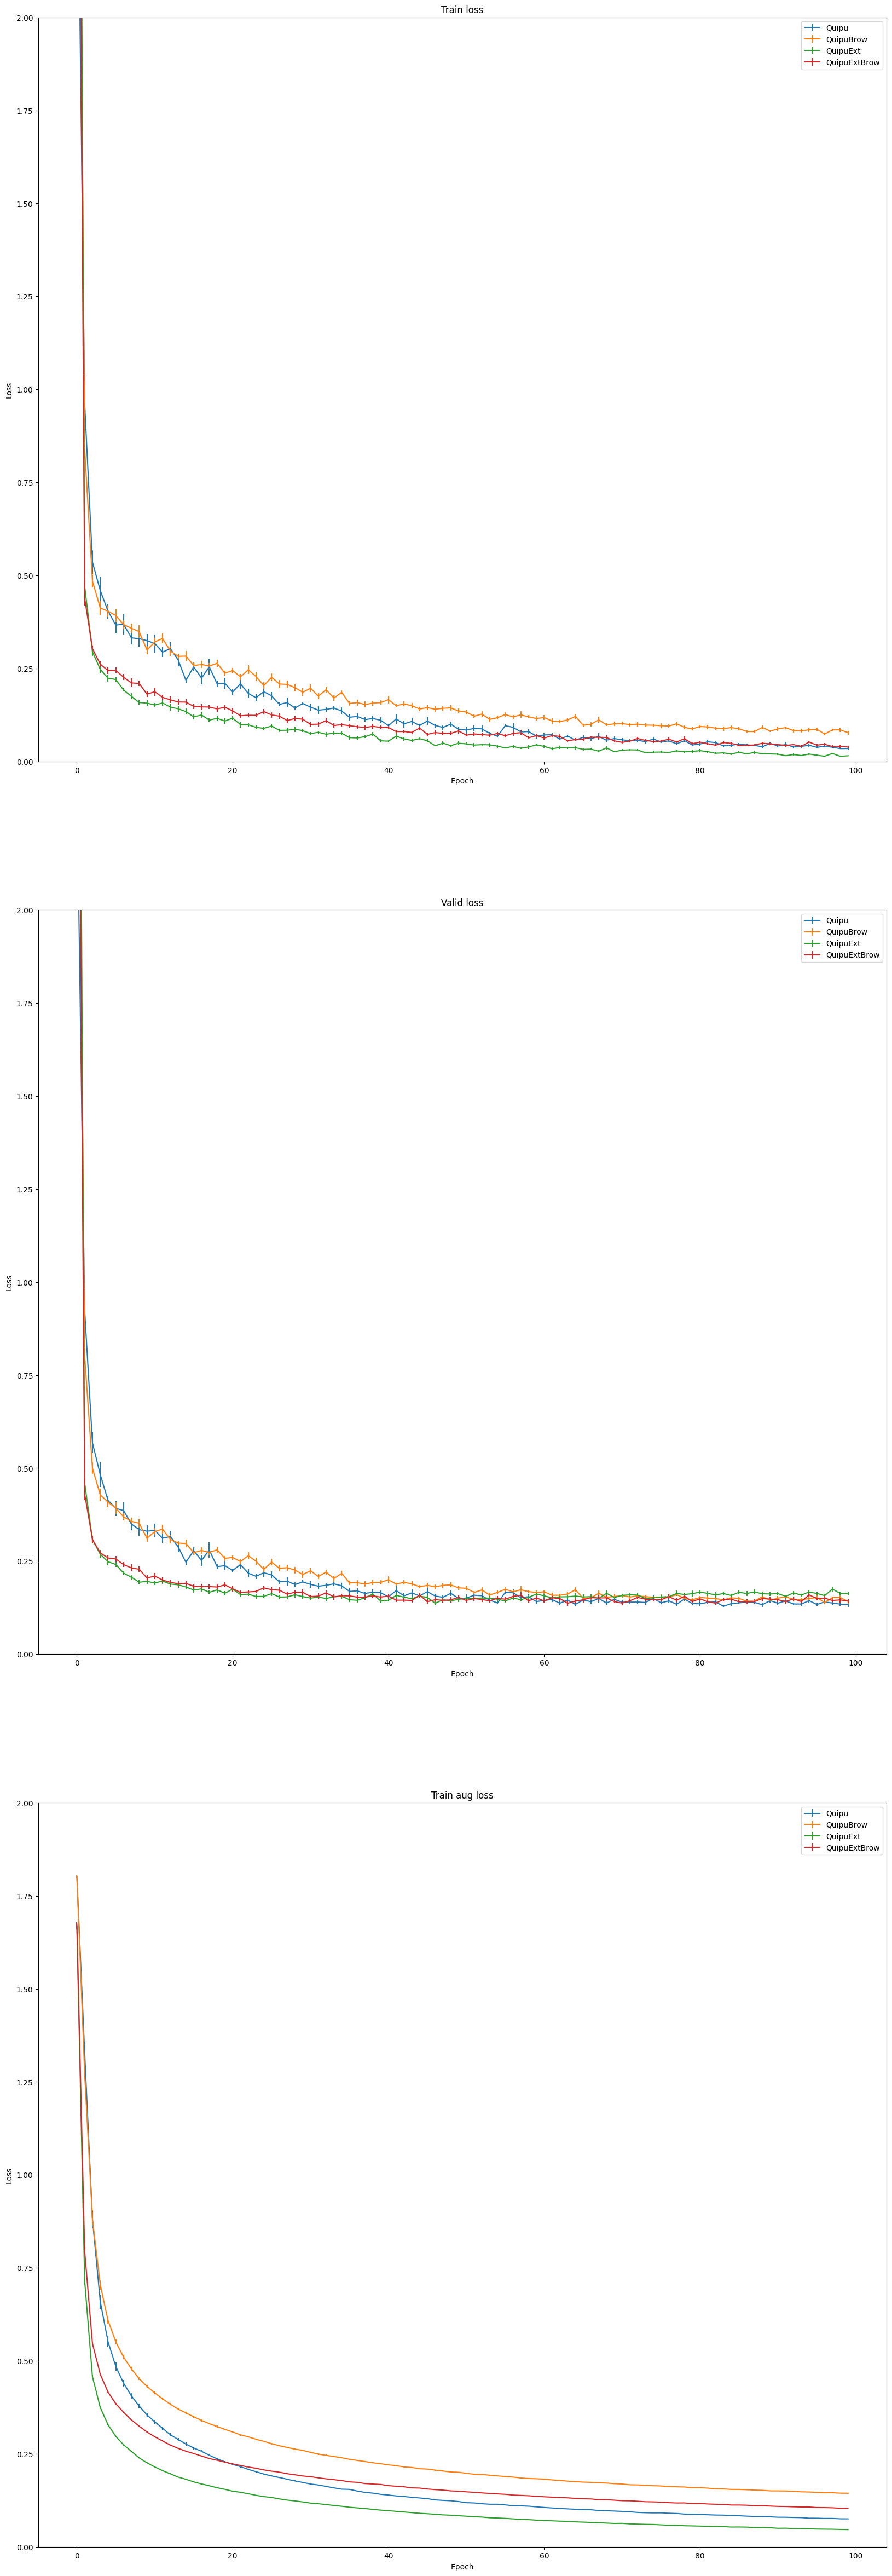

In [9]:
folder_quipu,file_QuipuFinalBrow=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_12-11-14_QuipuFinalBrow_log.txt")
_,file_QuipuFinalBrow2=get_folder_and_filepath(results_newNN_folder,"Quipu","20240421_19-50-42_QuipuFinalBrow_log.txt")
df_extra=get_runs_of_experiment(file_QuipuFinalBrow2,folder_quipu)
df_QuipuBrowFinal=get_runs_of_experiment(file_QuipuFinalBrow,folder_quipu)
df_QuipuBrowFinal=pd.concat([df_QuipuBrowFinal,df_extra]);

folder_quipu,file_QuipuFinal=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_12-12-25_QuipuFinalNoBrow_log.txt")
df_QuipuFinal=get_runs_of_experiment(file_QuipuFinal,folder_quipu)

#Multiple runs because they crashed at 10 trainings!
folder_quipu,file_QuipuExtFinalBrow=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_15-28-23_QuipuExtBrowFinal_log.txt")
_,file_QuipuExtFinalBrow2=get_folder_and_filepath(results_newNN_folder,"Quipu","20240421_19-49-01_QuipuExtBrowFinal_log.txt")
df_extra=get_runs_of_experiment(file_QuipuExtFinalBrow2,folder_quipu)
df_QuipuExtFinalBrow=get_runs_of_experiment(file_QuipuExtFinalBrow,folder_quipu)
df_QuipuExtFinalBrow=pd.concat([df_QuipuExtFinalBrow,df_extra]);

folder_quipu,file_QuipuExtFinal=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_15-28-23_QuipuExtFinal_log.txt")
_,file_QuipuExtFinal2=get_folder_and_filepath(results_newNN_folder,"Quipu","20240421_19-48-59_QuipuExtFinal_log.txt")
df_extra=get_runs_of_experiment(file_QuipuExtFinal2,folder_quipu)
df_QuipuExtFinal=get_runs_of_experiment(file_QuipuExtFinal,folder_quipu)
df_QuipuExtFinal=pd.concat([df_QuipuExtFinal,df_extra]);

compare_dfs([df_QuipuFinal,df_QuipuBrowFinal,df_QuipuExtFinal,df_QuipuExtFinalBrow],["Quipu","QuipuBrow","QuipuExt","QuipuExtBrow"])

------------ Table comparison ----------------
           Name      Train Accuracy      Valid Accuracy       Test Accuracy  \
0     QuipuBrow  98.37+-0.20(98.77)  96.45+-0.32(97.11)  93.86+-0.36(94.34)   
1  QuipuExtBrow  98.92+-0.23(99.24)  96.84+-0.28(97.35)  93.90+-0.39(94.69)   
2      QuipuRes  98.67+-0.18(98.96)  96.61+-0.25(97.17)  93.80+-0.31(94.43)   

   nRuns  
0     18  
1     18  
2     11  
----------------------------------------------
------------ Plot comparison ----------------


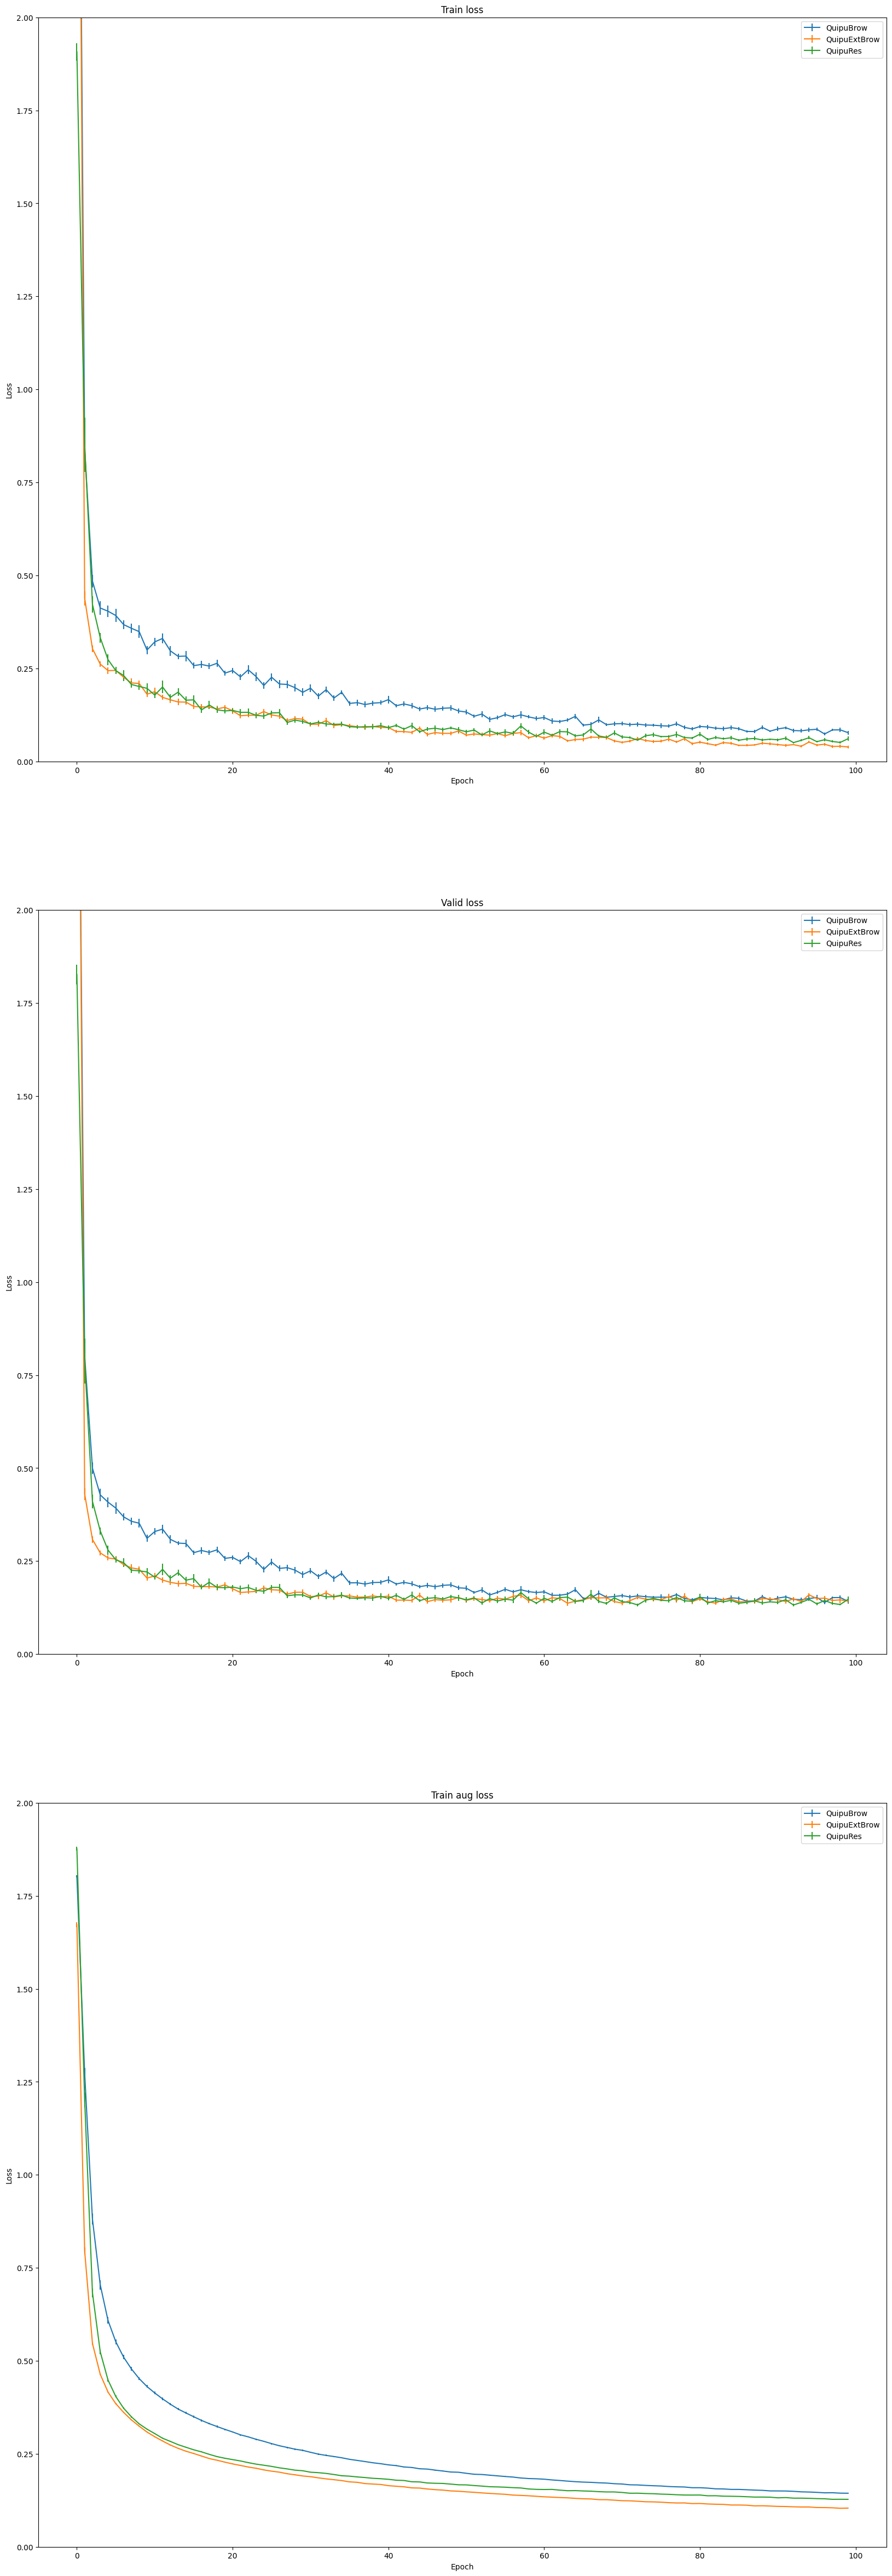

In [12]:
folder_quipuModif,file_QuipuResFinal=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240422_10-57-55_QuipuResFinal_log.txt")
df_QuipuResFinal=get_runs_of_experiment(file_QuipuResFinal,folder_quipuModif)
compare_dfs([df_QuipuBrowFinal,df_QuipuExtFinalBrow,df_QuipuResFinal],["QuipuBrow","QuipuExtBrow","QuipuRes"])